<a href="https://colab.research.google.com/github/Jammu452/Glaucoma-Segmentation/blob/main/encoder_and_decoder_only_cup_and_optical_disc_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

!unzip '/content/drive/MyDrive/origa.zip'

Archive:  /content/drive/MyDrive/origa.zip
  inflating: origa/readme.txt        
  inflating: origa/manual_labels.xlsx  
  inflating: origa/manual marking.rar  
  inflating: origa/manual marking/manual marking/629.mat  
  inflating: origa/manual marking/manual marking/625.mat  
  inflating: origa/manual marking/manual marking/626.mat  
  inflating: origa/manual marking/manual marking/648.mat  
  inflating: origa/manual marking/manual marking/633.mat  
  inflating: origa/manual marking/manual marking/650.mat  
  inflating: origa/manual marking/manual marking/619.mat  
  inflating: origa/manual marking/manual marking/627.mat  
  inflating: origa/manual marking/manual marking/618.mat  
  inflating: origa/manual marking/manual marking/622.mat  
  inflating: origa/manual marking/manual marking/628.mat  
  inflating: origa/manual marking/manual marking/632.mat  
  inflating: origa/manual marking/manual marking/615.mat  
  inflating: origa/manual marking/manual marking/635.mat  
  inflating: 

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pylab as plt
from PIL import Image

In [ ]:

image=np.array(Image.open('/content/origa/images/images/001.jpg'))

In [ ]:
image=np.array(Image.open('/content/origa/images/images/001.jpg'))


In [ ]:
image.shape

(2048, 3072, 3)

In [ ]:
import scipy.io
data=scipy.io.loadmat('/content/origa/manual marking/manual marking/001.mat')

In [ ]:
mask = cv2.resize(data['mask'],(256,256))

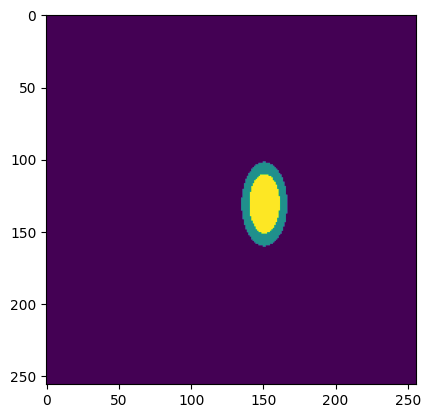

In [ ]:
plt.imshow(mask)

In [ ]:
images=[]
labels=[]
folders_I=os.listdir('/content/origa/images/images/')
len(folders_I)

576

In [ ]:
folders_M = os.listdir('/content/origa/manual marking/manual marking/')
len(folders_M)

576

In [ ]:
images=[]
labels=[]

for filename in sorted(folders_I):
  image=np.array(Image.open('/content/origa/images/images/'+filename))
  image=cv2.resize(image,(256,256))
  images.append(image)

In [ ]:
for filename in sorted(folders_M):
  data=scipy.io.loadmat('/content/origa/manual marking/manual marking/'+filename)
  mask=cv2.resize(data['mask'],(256,256))
  labels.append(mask)

In [ ]:
images=np.array(images)
labels=np.array(labels)

In [ ]:
np.unique(labels)

array([0, 1, 2], dtype=uint8)

In [ ]:
print(images.shape)
print(labels.shape)

(576, 256, 256, 3)
(576, 256, 256)


In [ ]:
np.unique(labels)

array([0, 1, 2], dtype=uint8)

In [ ]:
from keras.utils import to_categorical
labels1=to_categorical(labels,3)

In [ ]:
len(labels1)
np.unique(labels1)

array([0., 1.])

In [ ]:
labels1[0].shape

(256, 256, 3)

In [ ]:
from sklearn.model_selection import train_test_split


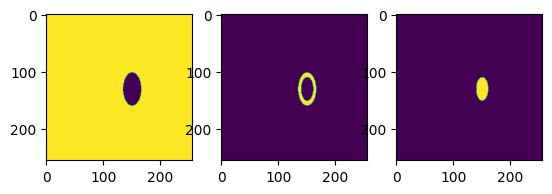

In [ ]:
fig,ax=plt.subplots(1,3)
ax[0].imshow(labels1[0][:,:,0])
ax[1].imshow(labels1[0][:,:,1])

ax[2].imshow(labels1[0][:,:,2])

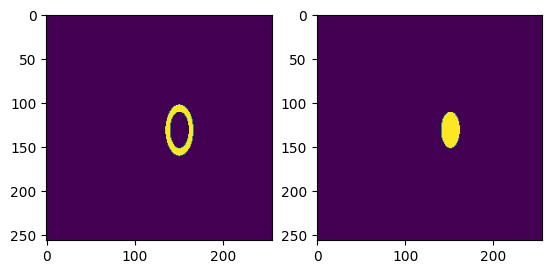

In [ ]:
optical_labels = labels1[:, :, :, 1:]
optical_labels.shape

fig,ax=plt.subplots(1,2)
ax[0].imshow(optical_labels[0][:,:,0])
ax[1].imshow(optical_labels[0][:,:,1])

In [ ]:

optical_labels = labels1[:, :, :, 1:]


x_train, x_test, y_train, y_test = train_test_split(images, optical_labels, test_size=0.2, random_state=42)
x_train_1, x_val, y_train_1, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [ ]:
x_train_1.shape,x_val.shape,x_test.shape

((368, 256, 256, 3), (92, 256, 256, 3), (116, 256, 256, 3))

In [ ]:
np.array(y_train_1).shape

(368, 256, 256, 2)

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D,concatenate

##model1

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the SpikingNeuronLayer placeholder (assuming it is already defined elsewhere)
class SpikingNeuronLayer(layers.Layer):
    def __init__(self, beta=0.9, threshold=0.8, **kwargs):
        super(SpikingNeuronLayer, self).__init__(**kwargs)
        self.beta = beta
        self.threshold = threshold

    def call(self, inputs, training=None):
        membrane_potential = self.beta * inputs
        spikes = tf.cast(membrane_potential >= self.threshold, tf.float32)
        reset_mask = membrane_potential >= self.threshold
        membrane_potential = tf.where(reset_mask, tf.zeros_like(membrane_potential), membrane_potential)
        return spikes

def inception_module(input_tensor, filters):
    f1, f3_r, f3, f5_r, f5, pool_proj = filters

    # 1x1 convolution
    conv_1x1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(input_tensor)

    # 3x3 convolution
    conv_3x3 = layers.Conv2D(f3_r, (1, 1), padding='same', activation='relu')(input_tensor)
    conv_3x3 = layers.Conv2D(f3, (3, 3), padding='same', activation='relu')(conv_3x3)

    # 5x5 convolution
    conv_5x5 = layers.Conv2D(f5_r, (1, 1), padding='same', activation='relu')(input_tensor)
    conv_5x5 = layers.Conv2D(f5, (5, 5), padding='same', activation='relu')(conv_5x5)

    # Max pooling and projection
    max_pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    max_pool = layers.Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(max_pool)

    # Concatenate filters
    output = layers.Concatenate()([conv_1x1, conv_3x3, conv_5x5, max_pool])

    return output

def create_inception_spiking_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Inception Module 1
    x = inception_module(x, filters=[64, 96, 128, 16, 32, 32])
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Inception Module 2
    x = inception_module(x, filters=[128, 128, 192, 32, 96, 64])
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Spiking Layer
    #x = SpikingNeuronLayer()(x)

    # Inception Module 3
    x = inception_module(x, filters=[192, 96, 208, 16, 48, 64])
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Decoder (Upsample back to 256x256)
    x = layers.Conv2DTranspose(192, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Final spiking layer and output

    outputs = layers.Conv2D(2, (1, 1), activation='sigmoid')(x)


    model = models.Model(inputs, outputs)
    return model

# Create the model with the modified inception architecture
inception_spiking_model = create_inception_spiking_model(input_shape=(256, 256, 3))
inception_spiking_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 96)   │          3,168 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 16)   │            528 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 32)   │              0 │ max_pooling2d[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │          2,112 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        110,720 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 32)   │         12,832 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 32)   │          1,056 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 256)  │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_5[0][0],        │
│                           │                        │                │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 256)  │          1,024 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 256)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 128)    │         32,896 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)   

 Total params: 2,101,570 (8.02 MB)

 Trainable params: 2,098,178 (8.00 MB)

 Non-trainable params: 3,392 (13.25 KB)

###training

In [ ]:
m = inception_spiking_model

In [ ]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth))

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


def dice_coef_OD(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true[:,:,0])
    y_pred_f = tf.keras.backend.flatten(y_pred[:,:,0])
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_OC(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true[:,:,1])
    y_pred_f = tf.keras.backend.flatten(y_pred[:,:,1])
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


In [ ]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + 1e-7)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

m.compile(optimizer='sgd',
              loss = bce_dice_loss,
              metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes = 2), dice_coefficient,dice_coef_OD,dice_coef_OC])


In [ ]:
# Import the Keras backend
from tensorflow import keras
# Alias the backend as K for brevity
K = keras.backend


In [ ]:
# Dice Coefficient (You already have this)'''

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + 1e-7)

# Specificity (True Negative Rate)
# def specificity(y_true, y_pred):
#     true_negatives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 0), tf.float32))
#     false_positives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 1), tf.float32))
#     specificity_value = true_negatives / (true_negatives + false_positives + 1e-7)
#     return specificity_value

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Sensitivity (True Positive Rate), using Keras' Recall metric
from tensorflow.keras.metrics import Recall as sensitivity

# IoU (Intersection over Union), using Keras' MeanIoU metric
iou = tf.keras.metrics.MeanIoU(num_classes=2)

# AUC (Area Under the Curve), using Keras' AUC metric
auc = tf.keras.metrics.AUC()

# Precision, using Keras' Precision metric
precision = tf.keras.metrics.Precision()

# Compile the model with all the metrics
m.compile(optimizer='sgd',
          loss=bce_dice_loss,
          metrics=[
              'accuracy',              # Overall accuracy
              iou,                     # Intersection over Union
              dice_coefficient,         # Dice Coefficient
              dice_coef_OD,             # Assuming these are defined elsewhere
              dice_coef_OC,             # Assuming these are defined elsewhere
              specificity,              # Custom specificity function
              sensitivity(),            # Sensitivity (Recall)
              auc,                      # Area Under the Curve
              precision                 # Precision
          ])


In [ ]:
np.unique(x_train_1)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
x_train_1=x_train_1/255
x_val=x_val/255
x_test=x_test/255

In [ ]:
history = m.fit(x_train_1, y_train_1, batch_size=2, epochs=100, validation_data = (x_val, y_val))


Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 74ms/step - accuracy: 0.5487 - auc: 0.5148 - dice_coef_oc: 0.0024 - dice_coef_od: 0.0021 - dice_coefficient: 0.0159 - loss: 1.6523 - mean_io_u_1: 0.4937 - precision: 0.0091 - recall: 0.3895 - specificity: 0.6565 - val_accuracy: 0.7660 - val_auc: 0.5334 - val_dice_coef_oc: 0.0034 - val_dice_coef_od: 0.0032 - val_dice_coefficient: 0.0156 - val_loss: 1.3334 - val_mean_io_u_1: 0.4960 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6035 - auc: 0.5568 - dice_coef_oc: 0.0041 - dice_coef_od: 0.0038 - dice_coefficient: 0.0164 - loss: 1.2973 - mean_io_u_1: 0.4937 - precision: 0.0167 - recall: 0.0346 - specificity: 0.9842 - val_accuracy: 0.6651 - val_auc: 0.5268 - val_dice_coef_oc: 0.0061 - val_dice_coef_od: 0.0056 - val_dice_coefficient: 0.0154 - val_loss: 1.1765 - val_mean_io_u_1: 0.4960 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_specifi

In [ ]:
m.save_weights('cupandDisctrainedcnn_new.weights.h5')

In [ ]:
m.evaluate(x_test,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.6280 - auc: 0.9353 - dice_coef_oc: 0.8524 - dice_coef_od: 0.8828 - dice_coefficient: 0.8018 - loss: 0.2223 - mean_io_u_1: 0.5945 - precision: 0.8152 - recall: 0.7948 - specificity: 0.9985


[0.22023963928222656,
 0.6332492232322693,
 0.5968958735466003,
 0.8025588989257812,
 0.888976514339447,
 0.85968416929245,
 0.9985803961753845,
 0.7940084934234619,
 0.9347620010375977,
 0.8184954524040222]

In [ ]:
T=x_test[0]
T=np.expand_dims(T,axis=0)
out2=m.predict(T)

y_test[0].shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


(256, 256, 2)

In [ ]:
np.unique(out2)

array([3.5383386e-21, 2.0111619e-20, 2.6946631e-20, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

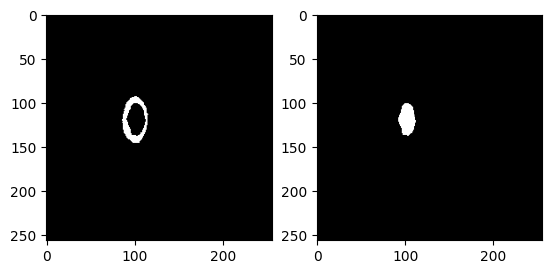

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(out2[0][:,:,0]>0.8, cmap='gray')  # Channel 0
ax[1].imshow(out2[0][:,:,1]>0.8, cmap='gray')  # Channel 1
# Channel 2
# ax[2].imshow(y_test[0][:,:,2], cmap='gray')
plt.show()

##model2

In [ ]:
def create_inception_spiking_model2(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Inception Module 1
    x = inception_module(x, filters=[64, 96, 128, 16, 32, 32])
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = SpikingNeuronLayer()(x)  # Add spiking layer

    # Inception Module 2
    x = inception_module(x, filters=[128, 128, 192, 32, 96, 64])
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = SpikingNeuronLayer()(x)  # Add spiking layer

    # Inception Module 3
    x = inception_module(x, filters=[192, 96, 208, 16, 48, 64])
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = SpikingNeuronLayer()(x)  # Add spiking layer

    # Decoder (Upsample back to 256x256)
    x = layers.Conv2DTranspose(192, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # x = SpikingNeuronLayer()(x)  # Add spiking layer

    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # x = SpikingNeuronLayer()(x)  # Add spiking layer

    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # x = SpikingNeuronLayer()(x)  # Add spiking layer

    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # x = SpikingNeuronLayer()(x)  # Add spiking layer

    # Final output
    outputs = layers.Conv2D(2, (1, 1), activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

# Create the model with spiking layers
inception_spiking_model2 = create_inception_spiking_model2(input_shape=(256, 256, 3))
inception_spiking_model2.summary()

m2 = inception_spiking_model2

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 256, 256, 32)   │            128 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 128, 128, 32)   │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 96)   │          3,168 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 128, 128, 16)   │            528 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 128, 128, 32)   │              0 │ max_pooling2d_7[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 64)   │          2,112 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 128, 128, 128)  │        110,720 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 128, 128, 32)   │         12,832 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 128, 128, 32)   │          1,056 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 128, 128, 256)  │              0 │ conv2d_21[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_23[0][0],       │
│                           │                        │                │ conv2d_25[0][0],       │
│                           │                        │                │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 128, 128, 256)  │          1,024 │ concatenate_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 64, 256)    │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spiking_neuron_layer      │ (None, 64, 64, 256)    │              0 │ max_pooling2d_9[0][0]  │
│ (SpikingNeuronLayer) 

 Total params: 2,101,570 (8.02 MB)

 Trainable params: 2,098,178 (8.00 MB)

 Non-trainable params: 3,392 (13.25 KB)

In [ ]:
# Assuming the weights are in your Google Drive under 'MyDrive/model_weights'
m2.load_weights('/content/cupandDisctrainedcnn_new.weights.h5')

###training

In [ ]:
# Dice Coefficient (You already have this)'''

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + 1e-7)

# Specificity (True Negative Rate)
# def specificity(y_true, y_pred):
#     true_negatives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 0), tf.float32))
#     false_positives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 1), tf.float32))
#     specificity_value = true_negatives / (true_negatives + false_positives + 1e-7)
#     return specificity_value

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Sensitivity (True Positive Rate), using Keras' Recall metric
from tensorflow.keras.metrics import Recall as sensitivity

# IoU (Intersection over Union), using Keras' MeanIoU metric
iou = tf.keras.metrics.MeanIoU(num_classes=2)

# AUC (Area Under the Curve), using Keras' AUC metric
auc = tf.keras.metrics.AUC()

# Precision, using Keras' Precision metric
precision = tf.keras.metrics.Precision()

# Compile the model with all the metrics
m2.compile(optimizer='sgd',
          loss=bce_dice_loss,
          metrics=[
              'accuracy',              # Overall accuracy
              iou,                     # Intersection over Union
              dice_coefficient,         # Dice Coefficient
              dice_coef_OD,             # Assuming these are defined elsewhere
              dice_coef_OC,             # Assuming these are defined elsewhere
              specificity,              # Custom specificity function
              sensitivity(),            # Sensitivity (Recall)
              auc,                      # Area Under the Curve
              precision                 # Precision
          ])


In [ ]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth))

def overall_dice_coef(y_true, y_pred, smooth=1):
    """
    Calculates the overall Dice coefficient as the average of
    Dice coefficients for optic disc (OD) and optic cup (OC).
    """
    dice_od = dice_coef_OD(y_true, y_pred, smooth)
    dice_oc = dice_coef_OC(y_true, y_pred, smooth)
    return (dice_od + dice_oc) / 2.0

def dice_coef_OD(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true[:,:,0])
    y_pred_f = tf.keras.backend.flatten(y_pred[:,:,0])
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_OC(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true[:,:,1])
    y_pred_f = tf.keras.backend.flatten(y_pred[:,:,1])
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


In [ ]:
history = m2.fit(x_train_1, y_train_1, batch_size=2, epochs=150, validation_data = (x_val, y_val))


Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.5570 - auc_1: 0.8622 - dice_coef_oc: 0.9583 - dice_coef_od: 0.9768 - dice_coefficient: 0.4197 - loss: 0.6393 - mean_io_u_2: 0.5142 - precision_1: 0.3784 - recall_1: 0.5104 - specificity: 0.9934 - val_accuracy: 0.6913 - val_auc_1: 0.7378 - val_dice_coef_oc: 0.9675 - val_dice_coef_od: 0.9761 - val_dice_coefficient: 0.1682 - val_loss: 0.8772 - val_mean_io_u_2: 0.4960 - val_precision_1: 0.5752 - val_recall_1: 0.0843 - val_specificity: 0.9995
Epoch 2/150
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5756 - auc_1: 0.9287 - dice_coef_oc: 0.9623 - dice_coef_od: 0.9720 - dice_coefficient: 0.5600 - loss: 0.4793 - mean_io_u_2: 0.5314 - precision_1: 0.5065 - recall_1: 0.6632 - specificity: 0.9948 - val_accuracy: 0.6378 - val_auc_1: 0.9164 - val_dice_coef_oc: 0.9619 - val_dice_coef_od: 0.9726 - val_dice_coefficient: 0.5317 - val_loss: 0.5079 - val_mean_io_u_2: 0.5454 - val_precision_1: 0.4912 - val_recall_1: 0.6067 - val_specificit

In [ ]:
y_train_1.shape


(368, 256, 256, 2)

In [ ]:
history = m2.fit(x_train_1, y_train_1, batch_size=2, epochs=50, validation_data = (x_val, y_val))


Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4372 - auc_1: 0.9725 - dice_coef_oc: 0.9991 - dice_coef_od: 0.9969 - dice_coefficient: 0.8197 - loss: 0.1934 - mean_io_u_2: 0.4947 - precision_1: 0.8020 - recall_1: 0.8500 - specificity: 0.9983 - val_accuracy: 0.4431 - val_auc_1: 0.9382 - val_dice_coef_oc: 0.9993 - val_dice_coef_od: 0.9969 - val_dice_coefficient: 0.7029 - val_loss: 0.3249 - val_mean_io_u_2: 0.4982 - val_precision_1: 0.6561 - val_recall_1: 0.7618 - val_specificity: 0.9968
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4361 - auc_1: 0.9726 - dice_coef_oc: 0.9991 - dice_coef_od: 0.9970 - dice_coefficient: 0.8152 - loss: 0.1985 - mean_io_u_2: 0.4950 - precision_1: 0.7950 - recall_1: 0.8498 - specificity: 0.9982 - val_accuracy: 0.4540 - val_auc_1: 0.9287 - val_dice_coef_oc: 0.9993 - val_dice_coef_od: 0.9968 - val_dice_coefficient: 0.7063 - val_loss: 0.3203 - val_mean_io_u_2: 0.4974 - val_precision_1: 0.6815 - val_recall_1: 0.7363 - val_sp

In [ ]:
m2.save_weights("/content/cupandDisctrainedScnn.weights.h5")

In [ ]:
m2.evaluate(x_test,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.4486 - auc_1: 0.9265 - dice_coef_oc: 0.9888 - dice_coef_od: 0.9558 - dice_coefficient: 0.7079 - loss: 0.3181 - mean_io_u_2: 0.4967 - precision_1: 0.7050 - recall_1: 0.7222 - specificity: 0.9975


[0.3273044228553772,
 0.44347959756851196,
 0.4966471791267395,
 0.6982855796813965,
 0.9582720994949341,
 0.9894477725028992,
 0.9975256323814392,
 0.7125670909881592,
 0.9218378067016602,
 0.6990357637405396]

In [ ]:
T1=x_test[0]
T1=np.expand_dims(T1,axis=0)
out3=m2.predict(T1)

y_test[0].shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


(256, 256, 2)

In [ ]:
print(out3.min(),out3.max())

3.5935066e-16 1.0


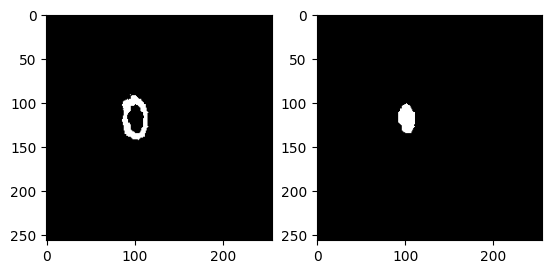

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(out3[0][:,:,0]>0.5, cmap='gray')  # Channel 0
ax[1].imshow(out3[0][:,:,1]>0.5, cmap='gray')  # Channel 1
# Channel 2
# ax[2].imshow(y_test[0][:,:,2], cmap='gray')
plt.show()

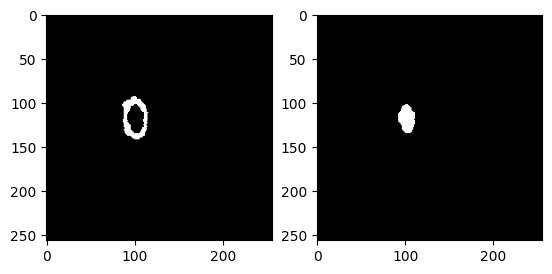

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(out3[0][:,:,0]>0.9, cmap='gray')  # Channel 0
ax[1].imshow(out3[0][:,:,1]>0.9, cmap='gray')  # Channel 1
# Channel 2
# ax[2].imshow(y_test[0][:,:,2], cmap='gray')
plt.show()

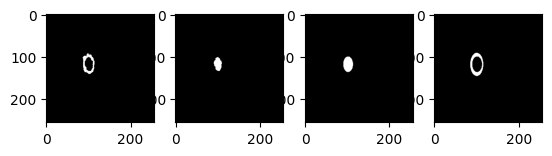

In [ ]:
fig, ax = plt.subplots(1, 4)
ax[0].imshow(out3[0][:,:,0]>0.98, cmap='gray')  # Channel 0
ax[1].imshow(out3[0][:,:,1]>0.98, cmap='gray')  # Channel 1
# Channel 2 - y_test only has 2 channels, so use index 1 instead of 2
ax[2].imshow(y_test[0][:,:,1], cmap='gray')
ax[3].imshow(y_test[0][:,:,0], cmap='gray') # Corrected to access channel 1
plt.show()